marketing_df : bank client data: 
https://www.kaggle.com/datasets/adityamhaske/bank-marketing-dataset?resource=download

1 - age (numeric)

2 - job : type of job (categorical:
"admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

* ##### related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: "unknown","telephone","cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

* ##### other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

* ##### Output variable (desired target):

17 - y - has the client subscribed a term deposit? (binary: "yes","no")

Missing Attribute Values: None



loan_df : Features:
https://www.kaggle.com/datasets/sahideseker/loan-default-prediction-dataset?utm_source=copilot.com&select=loan_default_prediction.csv

loan_id: Unique loan identifier

income: Monthly income of the applicant

loan_amount: Total amount of the loan

employment_status: Employment status (Employed / Unemployed)

default: Whether the loan was defaulted (1 = Yes, 0 = No)


INSEE API selected dataset 

1. Population 
   
    -'PTOT' : total legal population of the département (Private + collective housing),
   
    -'PCAP' : population of the préfecture city (eg : DEP‑75 → Paris, DEP‑95 → Cergy...),
   
    -'PMUN' : municipal population, meaning the **population living in private households** only is housing and urbanism indicators
selected dataset IDs

2. Income	DS_ERFS_MENAGE_SL	Revenu disponible et pauvreté
3. Unemployment 	DS_RP_EMPLOI_LR_PRINC	Population active et chômage
4. Housing	DS_RP_LOGEMENT_PRINC	Résidences principales
5. Age structure	DS_BTS_SAL_EQTP_SEX_AGE	Salaires par sexe et âge
6. Education	DS_RP_DIPLOMES_PRINC	Diplômes de la population

In [25]:
%load_ext autoreload
%autoreload 2
    
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import json
import importlib
import insee_api_functions
import functions

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

from imblearn.over_sampling import SMOTE

importlib.reload(insee_api_functions)
importlib.reload(functions)

df_uci = pd.read_csv("../data/raw/bank_marketing.csv", sep=';')
df_loan = pd.read_csv("../data/raw/loan_default.csv")
df_uci

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


## 1. The UCI dataset

### 1.1. Explore and clean the UCI dataset

In [2]:
from functions import explore_dataset

explore_dataset(df_uci)


=== Dataset ===

Shape: (45211, 17)

Columns:
 ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y']

Info:
<class 'pandas.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        45211 non-null  int64
 1   job        45211 non-null  str  
 2   marital    45211 non-null  str  
 3   education  45211 non-null  str  
 4   default    45211 non-null  str  
 5   balance    45211 non-null  int64
 6   housing    45211 non-null  str  
 7   loan       45211 non-null  str  
 8   contact    45211 non-null  str  
 9   day        45211 non-null  int64
 10  month      45211 non-null  str  
 11  duration   45211 non-null  int64
 12  campaign   45211 non-null  int64
 13  pdays      45211 non-null  int64
 14  previous   45211 non-null  int64
 15  poutcome   45211 non-null  s

Conclusion 
The UCI dataset looks clean and well-structured:

45,211 rows and 17 columns

No missing values

Columns are correctly typed (int and str)

In [3]:
from functions import clean_uci_dataset

df_uci_clean = clean_uci_dataset(df_uci)


Cleaning complete. Shape: (45211, 17)


In [4]:
df_uci_clean.info()
df_uci_clean.isna().sum()*100/len(df_uci_clean)


<class 'pandas.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age        45211 non-null  int64
 1   job        44923 non-null  str  
 2   marital    45211 non-null  str  
 3   education  43354 non-null  str  
 4   default    45211 non-null  str  
 5   balance    45211 non-null  int64
 6   housing    45211 non-null  str  
 7   loan       45211 non-null  str  
 8   contact    32191 non-null  str  
 9   day        45211 non-null  int64
 10  month      45211 non-null  str  
 11  duration   45211 non-null  int64
 12  campaign   45211 non-null  int64
 13  pdays      45211 non-null  int64
 14  previous   45211 non-null  int64
 15  poutcome   8252 non-null   str  
 16  y          45211 non-null  int64
dtypes: int64(8), str(9)
memory usage: 5.9 MB


age           0.000000
job           0.637013
marital       0.000000
education     4.107407
default       0.000000
balance       0.000000
housing       0.000000
loan          0.000000
contact      28.798301
day           0.000000
month         0.000000
duration      0.000000
campaign      0.000000
pdays         0.000000
previous      0.000000
poutcome     81.747805
y             0.000000
dtype: float64

In [5]:
df_uci_clean['contact_missing'] = df_uci_clean['contact'].isna().astype(int)
df_uci_clean['contact_missing'] 

0        1
1        1
2        1
3        1
4        1
        ..
45206    0
45207    0
45208    0
45209    0
45210    0
Name: contact_missing, Length: 45211, dtype: int64

In [6]:
from functions import handle_missing_values_uci

df_uci_final = handle_missing_values_uci(df_uci_clean)

df_uci_final.y.isna().value_counts()


Missing-value handling complete. Shape: (43193, 17)


y
False    43193
Name: count, dtype: int64

In [7]:
# Save cleaned and explored uci dataset
df_uci_final.to_csv("load_and_clean_uci_data_davy.csv", index=False)


### 1.2. EDA


[1] Target distribution
What: Distribution of the target variable.
Why: To check for class imbalance and understand baseline conversion rates.



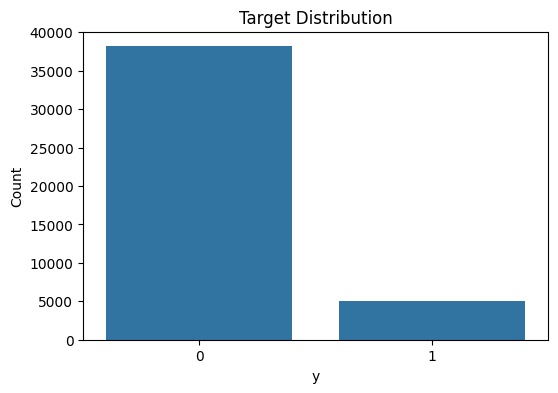


[2] Numeric feature distributions
What: Histograms of numeric variables.
Why: To detect skewness, outliers, and typical value ranges,
     which influence scaling choices and model robustness.



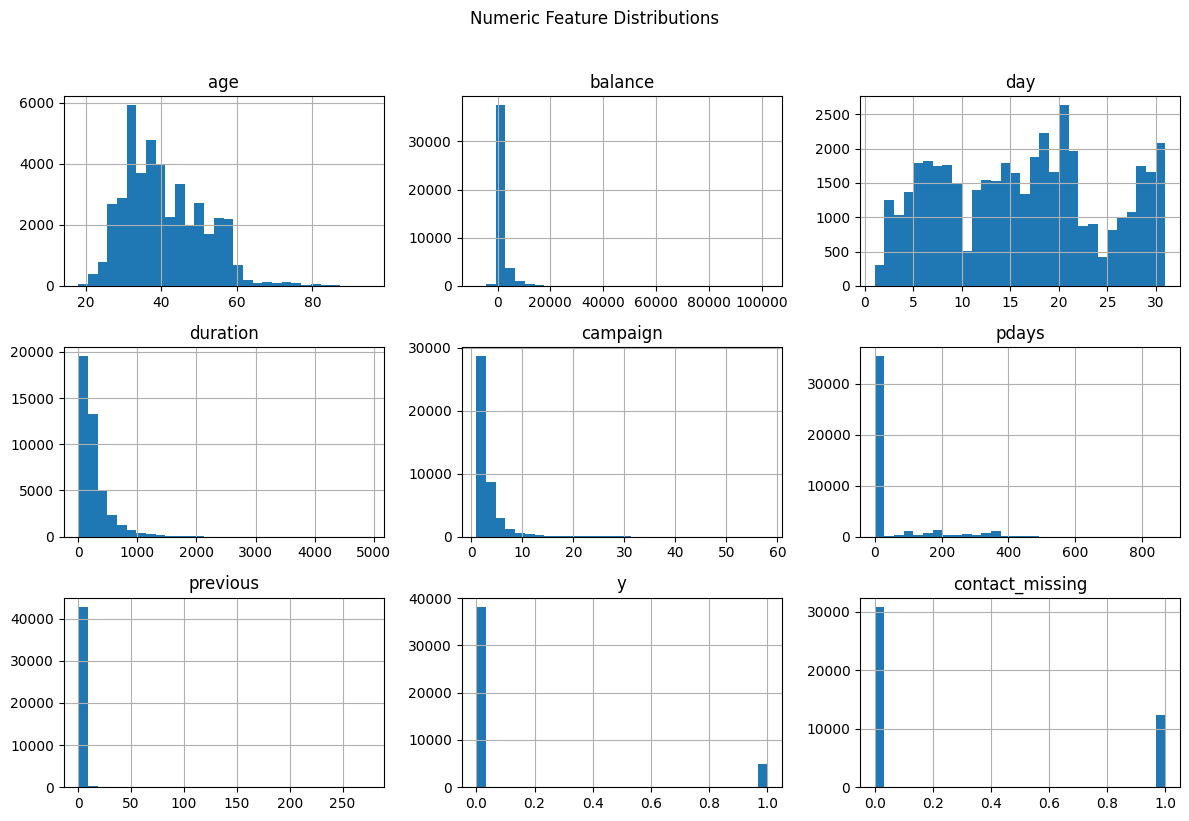


[3] Subscription rate by job
What: Mean target value by job category.
Why: To identify professional segments with higher conversion rates,
     which is key for marketing segmentation and prioritization.



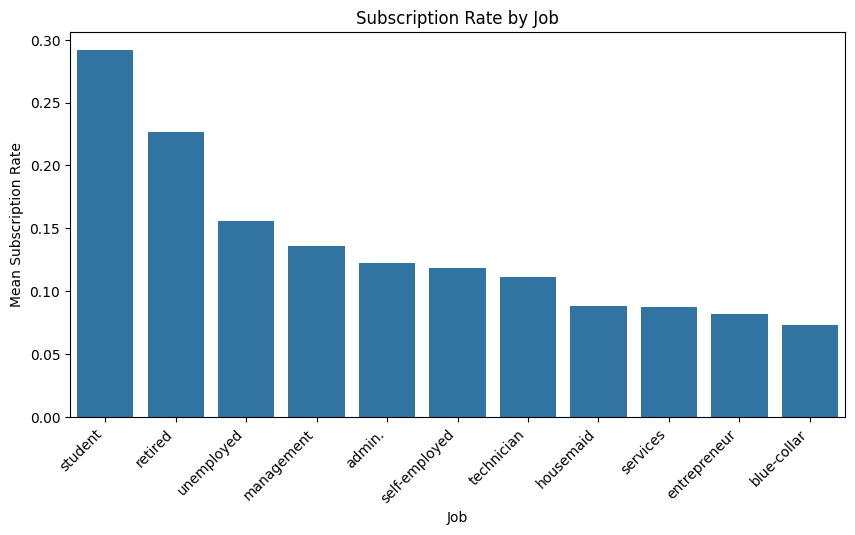


[4] Balance vs target
What: Boxplot of account balance by target.
Why: To test whether higher balances are associated with higher subscription rates,
     which supports targeting higher-value clients.



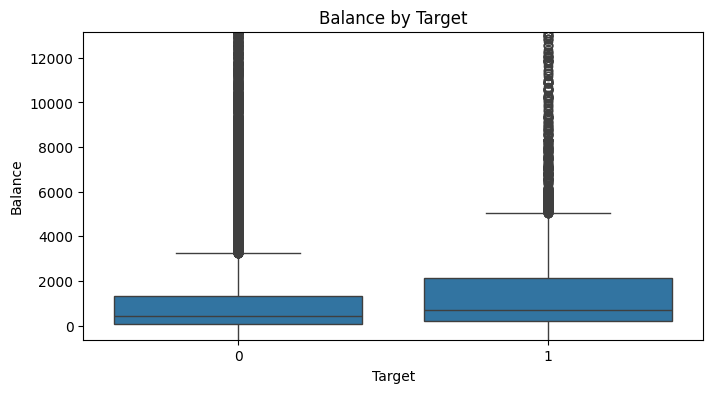


[5] Correlation matrix of numeric features
What: Correlation heatmap of numeric variables.
Why: To understand relationships between features and with the target,
     and to detect potential multicollinearity before modeling.



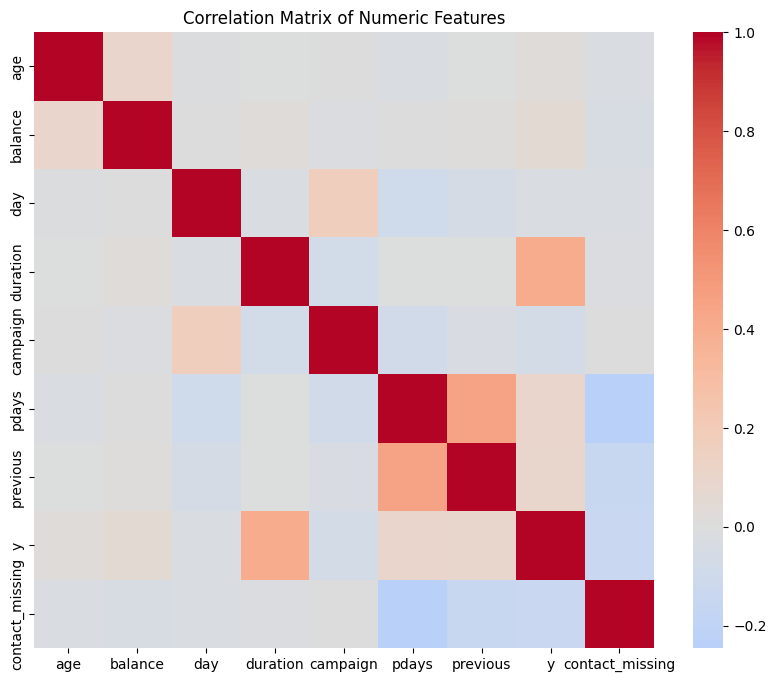

In [8]:
from functions import eda_uci_dataset
eda_uci_dataset(df_uci_final, target_col='y')

### 1.3. Feature Engineering

In [9]:
# Load cleaned dataset
df_uci_feat= pd.read_csv("load_and_clean_uci_data_davy.csv")
df_uci_feat

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,contact_missing
0,58,management,married,tertiary,no,2143,yes,no,missing,5,may,261,1,-1,0,0,1
1,44,technician,single,secondary,no,29,yes,no,missing,5,may,151,1,-1,0,0,1
2,33,entrepreneur,married,secondary,no,2,yes,yes,missing,5,may,76,1,-1,0,0,1
3,35,management,married,tertiary,no,231,yes,no,missing,5,may,139,1,-1,0,0,1
4,28,management,single,tertiary,no,447,yes,yes,missing,5,may,217,1,-1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43188,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,1,0
43189,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,1,0
43190,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,1,0
43191,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,0,0


## * H1: Can we predict whether a client will subscribe to a term deposit based on their profile and campaign data?

Our goal is to build a model that helps the marketing team target the right clients.

Steps :
First, we define our features and target. In our case, the target is 'y', which is categorical. This determines the type of machine learning model we use — supervised classification.

### Preprocessing: Encode + Scale + Concatenate

In [10]:
# 2. Separate features and target
X = df_uci_feat.drop(columns=['y', 'day', 'default', 'contact'])
y = df_uci_feat['y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=0)

0        0
1        0
2        0
3        0
4        0
        ..
43188    1
43189    1
43190    1
43191    0
43192    0
Name: y, Length: 43193, dtype: int64

In [12]:
X_train

,age,job,marital,education,balance,housing,loan,month,duration,campaign,pdays,previous,contact_missing
32154,32,management,married,tertiary,1683,yes,yes,apr,72,2,-1,0,0
1312,39,management,single,tertiary,375,yes,no,may,66,2,-1,0,1
13998,42,technician,married,secondary,422,yes,no,jul,400,1,-1,0,0
449,37,technician,single,secondary,17,yes,no,may,164,1,-1,0,1
7743,31,technician,single,tertiary,932,yes,no,jun,169,1,-1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32103,49,management,married,tertiary,603,yes,no,apr,590,3,-1,0,0
30403,27,technician,single,tertiary,4661,no,no,apr,114,1,-1,0,0
21243,49,blue-collar,married,primary,1898,no,no,aug,159,1,-1,0,0
42613,40,management,single,tertiary,15,no,yes,aug,4,1,-1,0,1


In [13]:
    # 3. Identify column types
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include='number').columns.tolist()


C:\Users\davyg\AppData\Local\Temp\ipykernel_17480\1133317036.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = X.select_dtypes(include='object').columns.tolist()


#### Encode categorical features to transform them in numerical columns

In [14]:
print(type(categorical_cols))
print(categorical_cols)


<class 'list'>
['job', 'marital', 'education', 'housing', 'loan', 'month']


In [16]:
# ask to give a numpy array instead of sparse
ohe = OneHotEncoder(sparse_output=False, drop='first') # To avoid having an sparse_matrix as output
ohe.fit(X_train[['job', 'marital', 'education', 'housing', 'loan', 'month']]) # The .fit() method determines the unique values of each column

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(34554, 27))

In [ ]:
# Transform train and test sets
X_train_trans_np = ohe.transform(X_train[['job', 'marital', 'education', 'housing', 'loan', 'month']])
X_test_trans_np = ohe.transform(X_test[['job', 'marital', 'education', 'housing', 'loan', 'month']])
X_test_trans_np

In [17]:
# Convert to DataFrames
X_train_trans_df = pd.DataFrame(X_train_trans_np, columns=ohe.get_feature_names_out(), index=X_train.index)
X_test_trans_df = pd.DataFrame(X_test_trans_np, columns=ohe.get_feature_names_out(), index=X_test.index)
X_train_trans_df

,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
32154,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1312,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32103,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21243,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42613,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Scale numerical features to Normalize numeric features

In [20]:
available_numerical_cols = [col for col in numerical_cols if col in X_train.columns]

scaler = StandardScaler()
scaler.fit(X_train[available_numerical_cols])

# Transform train and test sets
X_train_scaled_np = scaler.transform(X_train[available_numerical_cols])
X_test_scaled_np  = scaler.transform(X_test[available_numerical_cols])

# Convert to DataFrames
X_train_standarized = pd.DataFrame(X_train_scaled_np, columns=scaler.get_feature_names_out(), index=X_train.index)
X_test_standarized  = pd.DataFrame(X_test_scaled_np, columns=scaler.get_feature_names_out(), index=X_test.index)
X_test_standarized

,age,balance,duration,campaign,pdays,previous,contact_missing
12346,-0.639542,-0.483612,-0.539530,-0.248137,-0.412166,-0.242136,-0.627052
4006,0.600385,-0.547292,-0.254712,1.076409,-0.412166,-0.242136,1.594764
2482,-1.021058,-0.243563,-0.385574,-0.248137,-0.412166,-0.242136,1.594764
24728,-0.830300,-0.363254,4.783478,-0.579273,-0.412166,-0.242136,-0.627052
23743,0.123490,0.488586,-0.424063,-0.248137,-0.412166,-0.242136,-0.627052
...,...,...,...,...,...,...,...
28277,-0.830300,1.507127,0.149421,-0.579273,-0.412166,-0.242136,-0.627052
32094,-0.162647,-0.272902,-0.654996,0.083000,-0.412166,-0.242136,-0.627052
26188,0.886522,18.697633,0.230247,0.083000,-0.412166,-0.242136,-0.627052
32269,-0.162647,-0.081863,-0.212374,-0.579273,-0.412166,-0.242136,-0.627052


#### Concatenate transformed features

In [22]:
# Final model-ready datasets
X_train_full = pd.concat([X_train_standarized,X_train_trans_df], axis=1)
X_test_full = pd.concat([X_test_standarized,X_test_trans_df], axis=1)

### Train and evaluate baseline model on our dataset

In [24]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_full, y_train)

# Predictions
y_pred = model.predict(X_test_full)
y_proba = model.predict_proba(X_test_full)[:, 1]

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# Display
print(f"📊 LogisticRegression Classification Metrics:")
print(f"--------------------------")
print(f"Accuracy       : {acc:.2f}")
print(f"Precision      : {prec:.2f}")
print(f"Recall         : {rec:.2f}")
print(f"F1 Score       : {f1:.2f}")
print(f"AUC (ROC)      : {auc:.2f}")


📊 LogisticRegression Classification Metrics:
--------------------------
Accuracy       : 0.90
Precision      : 0.61
Recall         : 0.28
F1 Score       : 0.38
AUC (ROC)      : 0.89


In [ ]:
from sklearn.linear_model import LogisticRegression
from functions import classification_diagnostic_plot

# 1. Train on preprocessed features
log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_full, y_train)

# 2. Evaluate on preprocessed test features
classification_diagnostic_plot(
    log_reg_model,
    X_test_full,
    y_test,
    title="Logistic Regression Diagnostics"
)


### Interpretations:


Accuracy :	90% of predictions are correct overall — but this is misleading due to class imbalance.
Precision :	When the model predicts “yes” (1), it’s correct 61% of the time.
Recall	: The model only finds 28% of actual “yes” cases — it misses most subscribers.
F1 Score : A balance between precision and recall is low, due to poor recall.
AUC (ROC) : Very good discrimination between classes based on probability — the model ranks well.


711 false negatives, are actual subscribers that the model failed to identify
277 true positives means that the model correctly predicted subscribers
180 false positives, when the model predicted “yes” but actually “no”

**Business interpretation**

The company is missing 72% of potential subscribers

But when it targets someone, it's right 61% of the time

We  need better recall to identify more true subscribers.



In [ ]:
# let's adjusting the decision threshold to improve recall
# 1. Get predicted probabilities
y_proba = log_reg_model.predict_proba(X_test_full)[:, 1]

# 2. Apply custom threshold
threshold = 0.3   # I also need to try with a threshold 0.4, 0.2, or 0.1
y_pred_thresh = (y_proba >= threshold).astype(int)

# 3. Compute metrics
acc = accuracy_score(y_test, y_pred_thresh)
prec = precision_score(y_test, y_pred_thresh)
rec = recall_score(y_test, y_pred_thresh)
f1 = f1_score(y_test, y_pred_thresh)
auc = roc_auc_score(y_test, y_proba)

# 4. Display metrics
print(f"\n📊 Classification Metrics (Threshold = {threshold}):")
print("---------------------------------------------")
print(f"Accuracy        : {acc:.2f}")
print(f"Precision       : {prec:.2f}")
print(f"Recall          : {rec:.2f}")
print(f"F1 Score        : {f1:.2f}")
print(f"AUC (ROC)       : {auc:.2f}")

# 5. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_thresh, cmap="Greens")


517 false negatives, are actual subscribers that the model failed to identify
471 true positives means that the model correctly predicted subscribers
442 false positives, when the model predicted “yes” but actually “no”

In [ ]:

# 1. Train model with class weighting
log_reg_balanced = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg_balanced.fit(X_train_full, y_train)

# 2. Predictions
y_pred = log_reg_balanced.predict(X_test_full)
y_proba = log_reg_balanced.predict_proba(X_test_full)[:, 1]

# 3. Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

# 4. Display metrics
print("\n📊 Classification Metrics (Class Weight = 'balanced'):")
print("---------------------------------------------")
print(f"Accuracy        : {acc:.2f}")
print(f"Precision       : {prec:.2f}")
print(f"Recall          : {rec:.2f}")
print(f"F1 Score        : {f1:.2f}")
print(f"AUC (ROC)       : {auc:.2f}")

# 5. Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Greens")


### Train a Random Forest

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight='balanced',   # helps with imbalance
    random_state=0
)

rf_model.fit(X_train_full, y_train)

y_pred = rf_model.predict(X_test_full)
y_proba = rf_model.predict_proba(X_test_full)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("\n📊 Random Forest (no SMOTE):")
print("--------------------------------")
print(f"Accuracy  : {acc:.2f}")
print(f"Precision : {prec:.2f}")
print(f"Recall    : {rec:.2f}")
print(f"F1 Score  : {f1:.2f}")
print(f"AUC       : {auc:.2f}")


### We tune hyperparameters to optimize model performance. we will Train Random Forest on SMOTE‑balanced data
it means to create a synthetic examples rather than duplicating or deleting (as oversample or undersample do)

In [ ]:
#  Apply SMOTE to the training data
sm = SMOTE(random_state=0)

X_train_sm, y_train_sm = sm.fit_resample(X_train_full, y_train) # X_train_sm → oversampled feature matrix and y_train_sm → oversampled target vector


In [ ]:
rf_smote_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=0
)

rf_smote_model.fit(X_train_sm, y_train_sm)

y_pred = rf_smote_model.predict(X_test_full)
y_proba = rf_smote_model.predict_proba(X_test_full)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("\n📊 Random Forest + SMOTE:")
print("--------------------------------")
print(f"Accuracy  : {acc:.2f}")
print(f"Precision : {prec:.2f}")
print(f"Recall    : {rec:.2f}")
print(f"F1 Score  : {f1:.2f}")
print(f"AUC       : {auc:.2f}")


### Business Interpretation of business hypothesis: can we predict who will subscribe?

In [ ]:

answer :
metrics results: precision, recall, F1, AUC
confusion matrix and ROC curve : 

### Combining data again


In [ ]:
df_uci_clean.isna().sum()*100/len(df_uci_feat)

In [ ]:
df_uci_clean["y"].value_counts(dropna=False)

### 2. Explore and Clean the loan dataset

In [ ]:
from functions import explore_dataset

explore_dataset(df_loan)

In [ ]:
from functions import clean_loan_dataset

df_loan_clean = clean_loan_dataset(df_loan)
df_loan_clean.info()
df_loan_clean.head()


### Preprocessing: Encode + Scale + Concatenate

In [ ]:
from functions import preprocess_data

categorical_cols = ['job', 'marital', 'education', 'housing', 'loan', 'month']
numerical_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'contact_missing']

X_train_full, X_test_full, ohe, scaler = preprocess_data(
    X_train, X_test, categorical_cols, numerical_cols
)


### 3. Extract INSEE API DATA

In [ ]:
from insee_api_functions import fetch_melodi_dataset
df_insee = fetch_melodi_dataset("DS_POPULATIONS_REFERENCE", "DEP-44")
df_insee

In [ ]:
from insee_api_functions import fetch_melodi_dataset

# Test extraction for Île-de-France (example: Paris)
df_test = fetch_melodi_dataset("DS_POPULATIONS_REFERENCE", "DEP-75")
df_test.shape


In [ ]:
from insee_api_functions import fetch_dep_dataset

df_france = fetch_dep_dataset("DS_POPULATIONS_REFERENCE")
df_france.shape



In [ ]:
df_france.info()

In [ ]:
# Mapping dictionary for readable département names

departement_name_map = {
    "DEP-01": "Ain", "DEP-02": "Aisne", "DEP-03": "Allier", "DEP-04": "Alpes-de-Haute-Provence",
    "DEP-05": "Hautes-Alpes", "DEP-06": "Alpes-Maritimes", "DEP-07": "Ardèche", "DEP-08": "Ardennes",
    "DEP-09": "Ariège", "DEP-10": "Aube", "DEP-11": "Aude", "DEP-12": "Aveyron", "DEP-13": "Bouches-du-Rhône",
    "DEP-14": "Calvados", "DEP-15": "Cantal", "DEP-16": "Charente", "DEP-17": "Charente-Maritime",
    "DEP-18": "Cher", "DEP-19": "Corrèze", "DEP-2A": "Corse-du-Sud", "DEP-2B": "Haute-Corse",
    "DEP-21": "Côte-d'Or", "DEP-22": "Côtes-d'Armor", "DEP-23": "Creuse", "DEP-24": "Dordogne",
    "DEP-25": "Doubs", "DEP-26": "Drôme", "DEP-27": "Eure", "DEP-28": "Eure-et-Loir", "DEP-29": "Finistère",
    "DEP-30": "Gard", "DEP-31": "Haute-Garonne", "DEP-32": "Gers", "DEP-33": "Gironde", "DEP-34": "Hérault",
    "DEP-35": "Ille-et-Vilaine", "DEP-36": "Indre", "DEP-37": "Indre-et-Loire", "DEP-38": "Isère",
    "DEP-39": "Jura", "DEP-40": "Landes", "DEP-41": "Loir-et-Cher", "DEP-42": "Loire", "DEP-43": "Haute-Loire",
    "DEP-44": "Loire-Atlantique", "DEP-45": "Loiret", "DEP-46": "Lot", "DEP-47": "Lot-et-Garonne",
    "DEP-48": "Lozère", "DEP-49": "Maine-et-Loire", "DEP-50": "Manche", "DEP-51": "Marne", "DEP-52": "Haute-Marne",
    "DEP-53": "Mayenne", "DEP-54": "Meurthe-et-Moselle", "DEP-55": "Meuse", "DEP-56": "Morbihan",
    "DEP-57": "Moselle", "DEP-58": "Nièvre", "DEP-59": "Nord", "DEP-60": "Oise", "DEP-61": "Orne",
    "DEP-62": "Pas-de-Calais", "DEP-63": "Puy-de-Dôme", "DEP-64": "Pyrénées-Atlantiques",
    "DEP-65": "Hautes-Pyrénées", "DEP-66": "Pyrénées-Orientales", "DEP-67": "Bas-Rhin", "DEP-68": "Haut-Rhin",
    "DEP-69": "Rhône", "DEP-70": "Haute-Saône", "DEP-71": "Saône-et-Loire", "DEP-72": "Sarthe",
    "DEP-73": "Savoie", "DEP-74": "Haute-Savoie", "DEP-75": "Paris", "DEP-76": "Seine-Maritime",
    "DEP-77": "Seine-et-Marne", "DEP-78": "Yvelines", "DEP-79": "Deux-Sèvres", "DEP-80": "Somme",
    "DEP-81": "Tarn", "DEP-82": "Tarn-et-Garonne", "DEP-83": "Var", "DEP-84": "Vaucluse", "DEP-85": "Vendée",
    "DEP-86": "Vienne", "DEP-87": "Haute-Vienne", "DEP-88": "Vosges", "DEP-89": "Yonne", "DEP-90": "Territoire de Belfort",
    "DEP-91": "Essonne", "DEP-92": "Hauts-de-Seine", "DEP-93": "Seine-Saint-Denis", "DEP-94": "Val-de-Marne",
    "DEP-95": "Val-d’Oise", "DEP-971": "Guadeloupe", "DEP-972": "Martinique", "DEP-973": "Guyane",
    "DEP-974": "La Réunion", "DEP-976": "Mayotte"
}

df_france["departement_name"] = df_france["departement_code"].map(departement_name_map)


In [ ]:
# Rename all columns to match the format
df_france.rename(columns={
    "GEO": "geo_code",
    "FREQ": "frequency",
    "TIME_PERIOD": "year",
    "POPREF_MEASURE": "population_type",
    "OBS_VALUE_NIVEAU": "population_value",
    "departement_code": "departement_code",  # already correct
    "departement_name": "departement_name"   # newly added
}, inplace=True)


In [ ]:
list(df_france['population_type'].unique())

In [ ]:
#df_france.to_csv("insee_population_by_departement.csv", index=False)


In [ ]:
import requests, json

url = "https://api.insee.fr/melodi/catalog/all"
response = requests.get(url)
raw_data = json.loads(response.content)

print(type(raw_data))
print(len(raw_data))
print(raw_data[0])


In [ ]:
response.json()


In [ ]:
from insee_api_functions import list_melodi_datasets

catalog = list_melodi_datasets()
catalog.head()



In [ ]:
#Income datasets
revenu_df = catalog[catalog["title_fr"].str.contains("revenu", case=False, na=False)]
revenu_df

In [ ]:
# Unemployment datasets
chomage_df = catalog[catalog["title_fr"].str.contains("chômage", case=False, na=False)]
chomage_df

In [ ]:
# Unemployment datasets
logement_df = catalog[catalog["title_fr"].str.contains("logement", case=False, na=False)]
chomage_df

In [ ]:
# Unemployment datasets
age_df = catalog[catalog["title_fr"].str.contains("âge", case=False, na=False)]
age_df

In [ ]:
# Unemployment datasets
education_df = catalog[catalog["title_fr"].str.contains("diplôme|scolarité|éducation", case=False, na=False)]
education_df

In [ ]:
# Save each DataFrame
revenu_df.to_csv("indicators_revenu.csv", index=False)
chomage_df.to_csv("indicators_chomage.csv", index=False)
logement_df.to_csv("indicators_logement.csv", index=False)
age_df.to_csv("indicators_age.csv", index=False)
education_df.to_csv("indicators_education.csv", index=False)


In [ ]:
from insee_api_functions import fetch_indicator_for_all_departements

df_income = fetch_indicator_for_all_departements("DS_ERFS_MENAGE_SL")
df_income.head()


In [ ]:
catalog.columns